<a href="https://colab.research.google.com/github/AntoninaRemizova/ML/blob/main/ML_class_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.linear_model import Lasso, LogisticRegression
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score,
    accuracy_score, f1_score, log_loss, roc_auc_score,
    confusion_matrix, classification_report, roc_curve, auc
)
from sklearn.utils.multiclass import unique_labels

In [2]:
sns.set_theme(style="whitegrid")

In [3]:
df = pd.read_excel("https://raw.githubusercontent.com/AntoninaRemizova/ML/refs/heads/main/Japan.xlsx")
df.head()

,Страна,Дата,Заражений,Выздоровлений,Смертей,Заражений за день,Выздоровлений за день,Смертей за день,Население страны,Тестов,Тестов за день
0,Япония,20.07.2020,25680,19603.0,988,418,392.0,2,127110047,562726,12114
1,Япония,21.07.2020,26312,20001.0,989,632,398.0,1,127110047,579083,16357
2,Япония,22.07.2020,27107,20482.0,990,795,481.0,1,127110047,587393,8310
3,Япония,23.07.2020,28088,20878.0,992,981,396.0,2,127110047,593088,5695
4,Япония,24.07.2020,28867,21173.0,995,779,295.0,3,127110047,602618,9530


In [4]:
df.columns = [
    'Country', 'Date', 'I', 'R', 'D', 'I_Daily', 'R_Daily', 'D_Daily', 'Population', 'T', 'T_Daily'
]
df.head()

,Country,Date,I,R,D,I_Daily,R_Daily,D_Daily,Population,T,T_Daily
0,Япония,20.07.2020,25680,19603.0,988,418,392.0,2,127110047,562726,12114
1,Япония,21.07.2020,26312,20001.0,989,632,398.0,1,127110047,579083,16357
2,Япония,22.07.2020,27107,20482.0,990,795,481.0,1,127110047,587393,8310
3,Япония,23.07.2020,28088,20878.0,992,981,396.0,2,127110047,593088,5695
4,Япония,24.07.2020,28867,21173.0,995,779,295.0,3,127110047,602618,9530


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 609 entries, 0 to 608
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Country     609 non-null    object 
 1   Date        609 non-null    object 
 2   I           609 non-null    int64  
 3   R           381 non-null    float64
 4   D           609 non-null    int64  
 5   I_Daily     609 non-null    int64  
 6   R_Daily     381 non-null    float64
 7   D_Daily     609 non-null    int64  
 8   Population  609 non-null    int64  
 9   T           609 non-null    int64  
 10  T_Daily     609 non-null    int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 52.5+ KB


In [6]:
df.dropna(inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 381 entries, 0 to 380
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Country     381 non-null    object 
 1   Date        381 non-null    object 
 2   I           381 non-null    int64  
 3   R           381 non-null    float64
 4   D           381 non-null    int64  
 5   I_Daily     381 non-null    int64  
 6   R_Daily     381 non-null    float64
 7   D_Daily     381 non-null    int64  
 8   Population  381 non-null    int64  
 9   T           381 non-null    int64  
 10  T_Daily     381 non-null    int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 35.7+ KB


In [7]:
df['Date'] = pd.to_datetime(df['Date'])
df['R'] = df['R'].astype(np.int64)
df['R_Daily'] = df['R_Daily'].astype(np.int64)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 381 entries, 0 to 380
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Country     381 non-null    object        
 1   Date        381 non-null    datetime64[ns]
 2   I           381 non-null    int64         
 3   R           381 non-null    int64         
 4   D           381 non-null    int64         
 5   I_Daily     381 non-null    int64         
 6   R_Daily     381 non-null    int64         
 7   D_Daily     381 non-null    int64         
 8   Population  381 non-null    int64         
 9   T           381 non-null    int64         
 10  T_Daily     381 non-null    int64         
dtypes: datetime64[ns](1), int64(9), object(1)
memory usage: 35.7+ KB


/tmp/ipython-input-3287326001.py:1: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'])


In [8]:
# Оценка эффективности контроля эпидемии
# 0, если кол-во заражений за день < кол-во выздоровлений за день
# 1, если кол-во заражений за день >= кол-во выздоровлений за день

df['Effective_Control'] = np.where(df['I_Daily'] >= df['R_Daily'], 1, 0)
df['Effective_Control'].value_counts()

,count
Effective_Control,
1,225
0,156


# Подготовка данных

In [9]:
Y_reg = df['I_Daily']
Y_class = df['Effective_Control']

X = df.drop(columns=['Country', 'I', 'D', 'R', 'I_Daily', 'Effective_Control'])

X['DayOfWeek'] = X['Date'].dt.dayofweek
X['DayOfYear'] = X['Date'].dt.dayofyear
X['Month'] = X['Date'].dt.month
X.drop(columns=['Date'], inplace=True)

X.head()

,R_Daily,D_Daily,Population,T,T_Daily,DayOfWeek,DayOfYear,Month
0,392,2,127110047,562726,12114,0,202,7
1,398,1,127110047,579083,16357,1,203,7
2,481,1,127110047,587393,8310,2,204,7
3,396,2,127110047,593088,5695,3,205,7
4,295,3,127110047,602618,9530,4,206,7


In [10]:
numeric = ['D_Daily', 'Population', 'T', 'T_Daily', 'R_Daily', 'DayOfYear']
categorical = ['DayOfWeek', 'Month']

In [11]:
preprocessor = make_column_transformer(
    (StandardScaler(), numeric),
    (OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical),
    remainder='passthrough'
)

In [12]:
X_train_raw, X_test_raw, y_train_reg, y_test_reg, y_train_class, y_test_class = train_test_split(
    X, Y_reg, Y_class, test_size=0.2, shuffle=False,
    random_state=42
)

X_train = preprocessor.fit_transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)

# Регрессия

In [13]:
reg_metrics = {}


def evaluate_regression_model(model, name, X_train, X_test, y_train, y_test, is_arima=False):
    if is_arima:
        model_fit = model.fit()
        y_pred = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, dynamic=False)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    y_pred[y_pred < 0] = 0

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100

    reg_metrics[name] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R^2': r2, 'MAPE (%)': mape, 'y_pred': y_pred}
    return y_pred


In [14]:
y_pred_lasso = evaluate_regression_model(
    Lasso(alpha=0.1, max_iter=10000, random_state=42),
    'Lasso', X_train, X_test, y_train_reg, y_test_reg
)

In [15]:
y_pred_rf = evaluate_regression_model(
    RandomForestRegressor(n_estimators=150, max_depth= 1, random_state=42),
    'RandomForest', X_train, X_test, y_train_reg, y_test_reg
)

In [16]:
arima_model = ARIMA(y_train_reg, order=(10, 1, 1))
y_pred_arima = evaluate_regression_model(
    arima_model,
    'ARIMA', X_train, X_test, y_train_reg, y_test_reg,
    is_arima=True)

In [17]:
reg_results_df = pd.DataFrame({
    'Модель': list(reg_metrics.keys()),
    'R^2': [m['R^2'] for m in reg_metrics.values()],
    'MSE': [m['MSE'] for m in reg_metrics.values()],
    'MAE': [m['MAE'] for m in reg_metrics.values()],
    'RMSE': [m['RMSE'] for m in reg_metrics.values()],
    'MAPE (%)': [m['MAPE (%)'] for m in reg_metrics.values()]
}).set_index('Модель')

print(reg_results_df.sort_values(by='RMSE',).to_markdown(floatfmt=".2f"))

| Модель       |   R^2 |        MSE |     MAE |    RMSE |   MAPE (%) |
|:-------------|------:|-----------:|--------:|--------:|-----------:|
| RandomForest |  0.14 | 7445146.60 | 1854.35 | 2728.58 |      60.54 |
| Lasso        |  0.05 | 8175460.48 | 1961.59 | 2859.28 |      63.06 |
| ARIMA        | -0.15 | 9949184.09 | 2659.75 | 3154.23 |     118.73 |


In [18]:
best_model_name = reg_results_df.sort_values(by='RMSE').index[0]
y_best_pred_reg = reg_metrics[best_model_name]['y_pred']

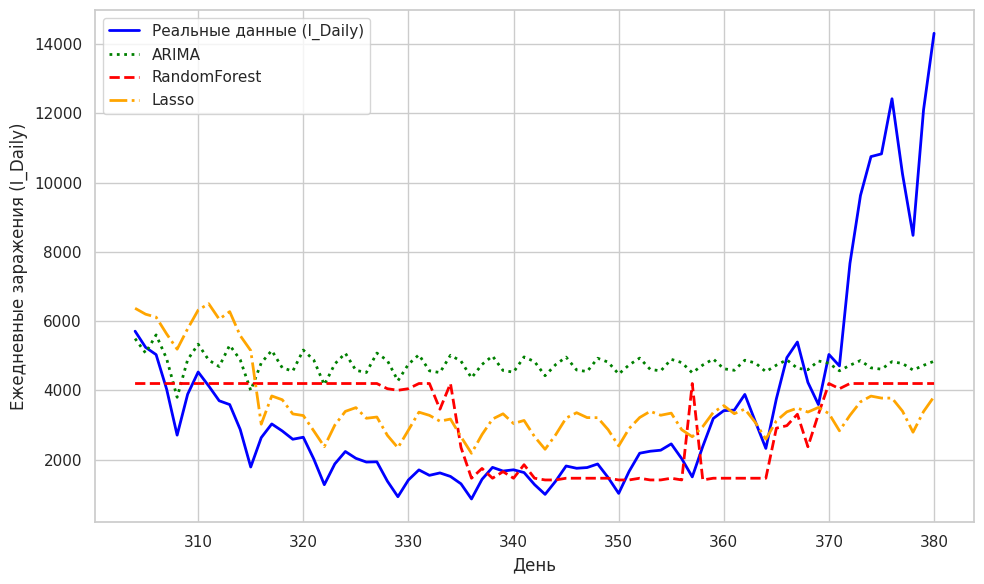

In [19]:
plt.figure(figsize=(10, 6))

test_indices = X_test_raw.index
plt.plot(test_indices, y_test_reg, label='Реальные данные (I_Daily)', color='blue', linewidth=2)

y_pred_arima_plot = reg_metrics['ARIMA']['y_pred']
if not np.all(np.isnan(y_pred_arima_plot)):
    plt.plot(test_indices, y_pred_arima_plot, label='ARIMA', color='green', linestyle=':', linewidth=2)

y_pred_rf_plot = reg_metrics['RandomForest']['y_pred']
plt.plot(test_indices, y_pred_rf_plot, label='RandomForest', color='red', linestyle='--', linewidth=2)

y_pred_lasso_plot = reg_metrics['Lasso']['y_pred']
plt.plot(test_indices, y_pred_lasso_plot, label='Lasso', color='orange', linestyle='-.', linewidth=2)

plt.xlabel('День')
plt.ylabel('Ежедневные заражения (I_Daily)')
plt.legend()
plt.tight_layout()
plt.show()

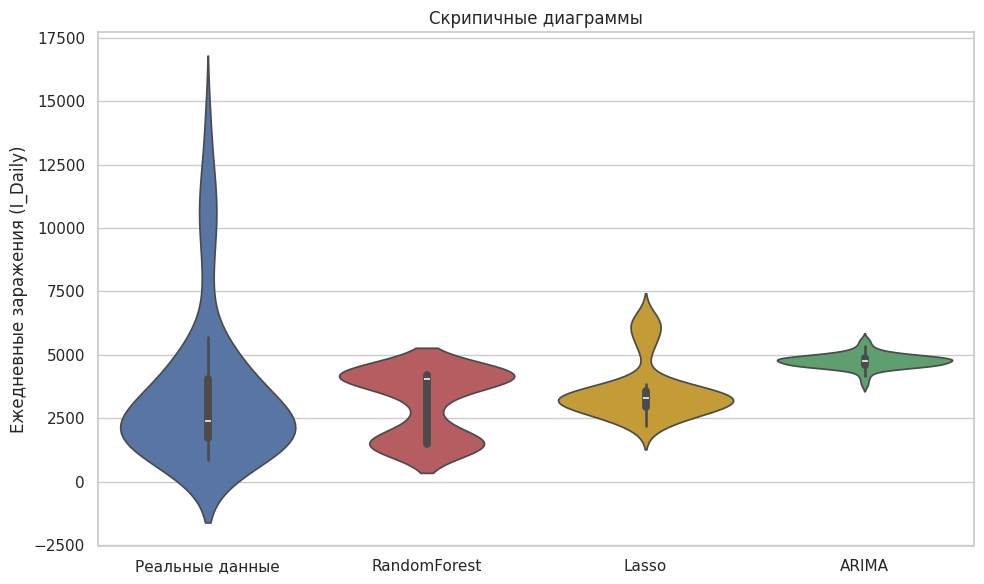

In [20]:
data_violin_dict = {
    'Реальные данные': y_test_reg,
    'RandomForest': reg_metrics['RandomForest']['y_pred'],
    'Lasso': reg_metrics['Lasso']['y_pred'],
    'ARIMA': reg_metrics['ARIMA']['y_pred']
}
data_violin = pd.DataFrame(data_violin_dict)
palette_colors = ['#4c72b0', '#c44e52', '#daa520', '#55a868']
plt.figure(figsize=(10, 6))
sns.violinplot(data=data_violin, palette=palette_colors[:len(data_violin.columns)])
plt.title('Скрипичные диаграммы')
plt.ylabel('Ежедневные заражения (I_Daily)')
plt.tight_layout()
plt.show()

# Классификация

In [21]:
reg_threshold = y_train_reg.median()
print(f"Порог: {reg_threshold}")

y_reg_to_class = (y_best_pred_reg > reg_threshold).astype(int)

Порог: 1498.5


In [22]:
classifiers = {
    'Reg': y_reg_to_class,
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'SVM': SVC(kernel='linear', C=1, probability=True, random_state=42),
    'NaiveBayes': GaussianNB(),
    'LogisticRegression': LogisticRegression(solver='liblinear', random_state=42)
}

class_results = []
y_proba_dict = {}

for name, model in classifiers.items():
    if name == 'Reg':
        y_pred = model
        y_proba = np.full((len(y_test_class), 2), np.nan)
        y_proba_dict[name] = y_proba
    else:
        model.fit(X_train, y_train_class)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)
        y_proba_dict[name] = y_proba


    accuracy = accuracy_score(y_test_class, y_pred)
    f1 = f1_score(y_test_class, y_pred, average='weighted')

    if name != 'Reg':
        logloss = log_loss(y_test_class, y_proba)
        roc_auc = roc_auc_score(y_test_class, y_proba[:, 1])
    else:
        logloss = np.nan
        roc_auc = np.nan

    class_results.append({
        'Модель': name,
        'Accuracy': accuracy,
        'F1-мера': f1,
        'LogLoss': logloss,
        'ROC AUC': roc_auc,
        'y_pred': y_pred
    })

class_results_df = pd.DataFrame(class_results)
print(class_results_df.sort_values(by='ROC AUC', ascending=False).to_markdown(floatfmt=".3f"))

|    | Модель             |   Accuracy |   F1-мера |   LogLoss |   ROC AUC | y_pred                                                                     |
|---:|:-------------------|-----------:|----------:|----------:|----------:|:---------------------------------------------------------------------------|
|  4 | LogisticRegression |      0.481 |     0.362 |     1.363 |     0.926 | [1 0 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 |
|    |                    |            |           |           |           |  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 |
|    |                    |            |           |           |           |  1 1 1]                                                                    |
|  2 | SVM                |      0.506 |     0.409 |     2.114 |     0.882 | [1 0 0 1 0 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 |
|    |                    |            |           |           |           |

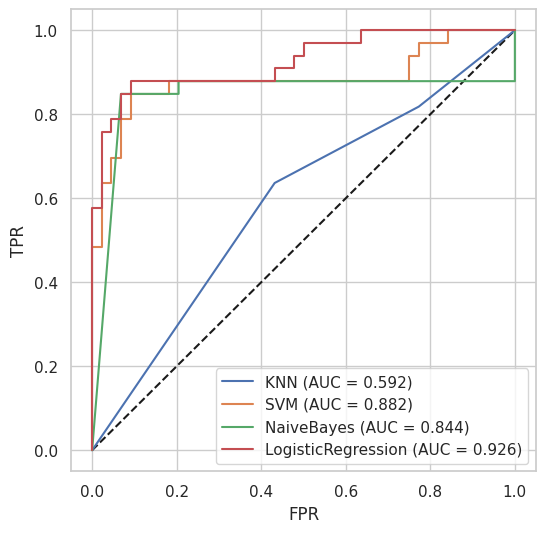

In [23]:
plt.figure(figsize=(6, 6))
plt.plot([0, 1], [0, 1], 'k--')

for name, y_proba in y_proba_dict.items():
    if name != 'Reg':
        fpr, tpr, _ = roc_curve(y_test_class, y_proba[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc="lower right")
plt.show()

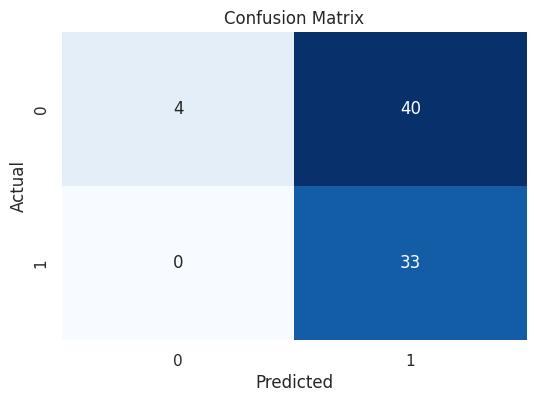

In [24]:
best_model_pred = class_results_df.loc[class_results_df['Модель'] == 'LogisticRegression', 'y_pred'].iloc[0]
cm = confusion_matrix(y_test_class, best_model_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [25]:
print(f"Баланс классов до:\n{Y_class.value_counts(normalize=True)}")

Баланс классов до:
Effective_Control
1    0.590551
0    0.409449
Name: proportion, dtype: float64


In [26]:
q75_r_daily = df['R_Daily'].quantile(0.75)
print(f"Новый порог = {q75_r_daily}")

Новый порог = 3221.0


In [27]:
Y_class_new = (df['I_Daily'] > q75_r_daily).astype(int)
print(f"Новый класс:\n{Y_class_new.value_counts(normalize=True)}")

Новый класс:
I_Daily
0    0.732283
1    0.267717
Name: proportion, dtype: float64


In [28]:
_, _, y_train_new, y_test_new = train_test_split(
    X, Y_class_new, test_size=0.2, shuffle=False, random_state=42
)

logreg_new = LogisticRegression(solver='liblinear', random_state=42)
logreg_new.fit(X_train, y_train_new)

y_pred_new = logreg_new.predict(X_test)
y_proba_new = logreg_new.predict_proba(X_test)

accuracy_new = accuracy_score(y_test_new, y_pred_new)
f1_new = f1_score(y_test_new, y_pred_new, average='weighted')
roc_auc_new = roc_auc_score(y_test_new, y_proba_new[:, 1])

accuracy_old = class_results_df.loc[class_results_df['Модель'] == 'LogisticRegression', 'Accuracy'].iloc[0]
f1_old = class_results_df.loc[class_results_df['Модель'] == 'LogisticRegression', 'F1-мера'].iloc[0]
roc_auc_old = class_results_df.loc[class_results_df['Модель'] == 'LogisticRegression', 'ROC AUC'].iloc[0]

print(f"Сравнение метрик:")
print(f"Исходный класс: Accuracy = {accuracy_old:.3f}, F1-мера = {f1_old :.3f}, ROC AUC = {roc_auc_old:.3f}")
print(f"Новый класс: Accuracy = {accuracy_new:.3f}, F1-мера = {f1_new:.3f}, ROC AUC = {roc_auc_new:.3f}")

Сравнение метрик:
Исходный класс: Accuracy = 0.481, F1-мера = 0.362, ROC AUC = 0.926
Новый класс: Accuracy = 0.364, F1-мера = 0.194, ROC AUC = 0.735
